#### Refs:

https://livebook.manning.com/book/time-series-forecasting-in-python-book/chapter-3/v-6    
https://arxiv.org/pdf/2008.03639.pdf   
https://arxiv.org/pdf/1801.04805.pdf   
https://www.researchgate.net/publication/321896417_Improving_Multivariate_Time_Series_Forecasting_with_Random_Walks_with_Restarts_on_Causality_Graphs  
https://www.researchgate.net/publication/283343527_Clustering_Random_Walk_Time_Series  
http://home.ustc.edu.cn/~zegang/Ref/project_quantum_random_walks.pdf   
https://www.researchgate.net/publication/235742777_A_Combination_of_Artificial_Neural_Network_and_Random_Walk_Models_for_Financial_Time_Series_Forecasting  
https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=3b7666b0ecf8a3ecf3cc9015c6df7e756fa08ef3  
https://www.sciencedirect.com/science/article/abs/pii/S0922142515000328   
https://arxiv.org/abs/1612.09344  
https://people.duke.edu/~rnau/411georw.htm    


Random Walk model assumes that a specific state $Y_t$ is a result of its lagged value $Y_{t-1}$ and a random shock, which might be either discrete or continuous. A commonly-used analogy is that of a drunkard who randomly steps either right or left when attempt going forward; that path will be a random walk.     

RW assumes that past displacements don't bring information about future movements.

$$ \^Y_T = Y_{t-1}$$

Let's peek at the daily closing of stock MGLU3 over the last two years. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

mglu = pd.read_csv('MGLU3_historical_data.csv')

mglu['Date'] = pd.to_datetime(mglu['Date'])
#mglu = mglu[mglu.Date < '2021-01-01'].reset_index()

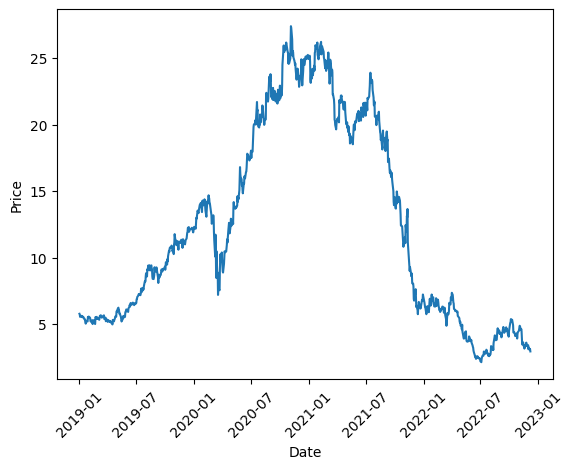

In [2]:
sns.lineplot(x="Date", y="Price", data=mglu)
_ = plt.xticks(rotation=45)

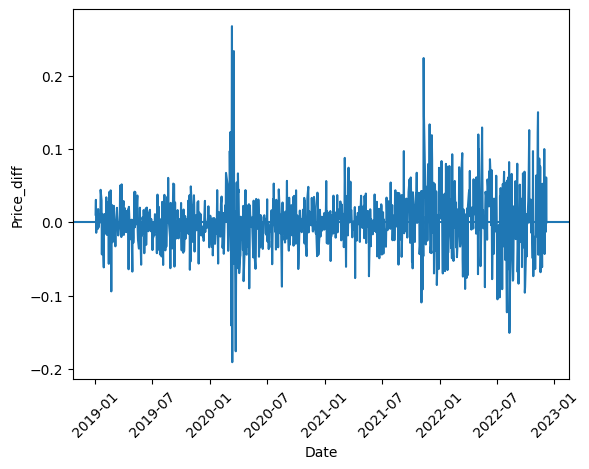

In [3]:
mglu["Price_diff"] = mglu["Price"].pct_change()
mglu["Price_diff"].fillna(0, inplace=True)
graph = sns.lineplot(x="Date", y="Price_diff", data=mglu)
graph.axhline(0)
_ = plt.xticks(rotation=45)

The daily returns of MGLU3 show an interesting pattern - despite the big upward trend of prices daily, the time series of daily returns have a 0-mean heteroskedasticity behavior. The autocorrelation plot can elucidate whether displacements are a path in modeling current observations.

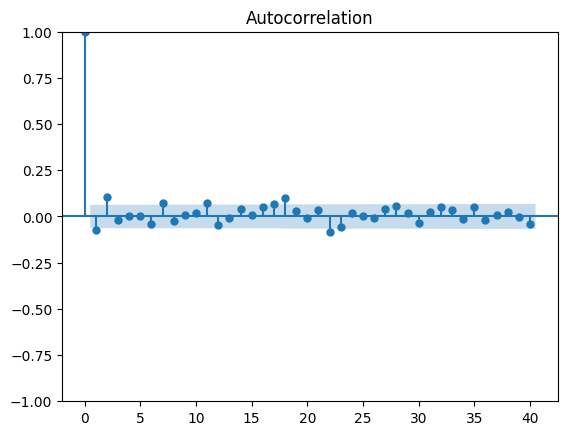

In [4]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(mglu["Price_diff"], lags=40)

plt.show()

Daily returns of MGLU3 reveals overall traits of `Random-walk-without-drift` models.


RW can also be viewed as an important case of an ARIMA model; the `ARIMA(0,1,0)`.

Specifying Random Walk models with PYMC3 is straightforward. We begin with a bayesian proposal that entails the MGLU3 model.

$$ \upsilon \sim exp(0.1) $$
$$ \sigma \sim exp(50) $$
$$ s_i \sim N(s_{i-1}, \sigma^2) $$
$$ log(x_i) \sim t(\upsilon, 0, exp(-2s_i)) $$

As long as most values fall around the mean of +/-0.1, the distribution of t-student is an appropriate adjustment. Super based on the 7th chapter, I'll do Prophet-based. https://facebook.github.io/prophet/. 

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd

In [6]:
RANDOM_SEED = 42

with pm.Model() as MGLU3:
    pct_change_mglu = pm.Data("data", mglu["Price_diff"], dims="Date", export_index_as_coords=True)
    
    nu = pm.Exponential("nu", 0.1, testval=5.0)
    
    sigma = pm.Exponential("sigma", 50, testval=5.0)
    
    s = pm.GaussianRandomWalk("s", sigma=sigma, dims="Date")
    
    volatility = pm.Deterministic("volatility_process", pm.math.exp(-2 * s) ** 0.5, dims="Date")
    
    x = pm.StudentT("x", nu=nu, sigma=volatility, observed=pct_change_mglu, dims="Date")
    
    linear_prior_predictive = pm.sample_prior_predictive()
    
with MGLU3:
    linear_trace = pm.sample(return_inferencedata=True)
    linear_posterior_predictive = pm.sample_posterior_predictive(trace=linear_trace)
    
def _sample(array, n_samples):
    """Little utility function, sample n_samples with replacement"""
    idx = np.random.choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, sigma, nu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 160 seconds.
The acceptance probability does not match the target. It is 0.6871398881061811, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


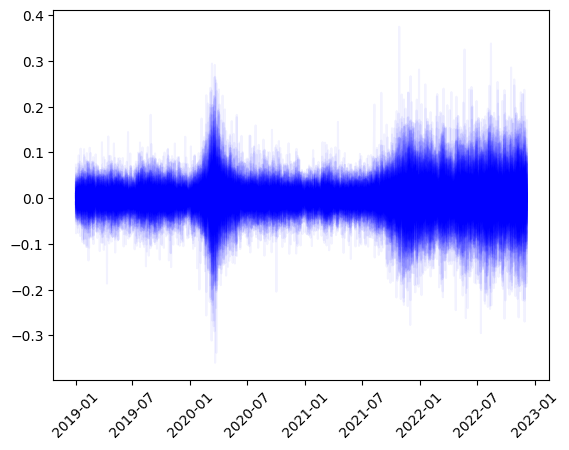

In [8]:
_ = plt.plot(
    mglu["Date"],
    _sample(linear_posterior_predictive["x"], 100).T,
    color="blue",
    alpha=0.05,
)
_ = plt.xticks(rotation=45)

BOM! It retains the overall picture. Time to forecast.

In [10]:
x.predict()

AttributeError: 'ObservedRV' object has no attribute 'predict'